In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define transformations (convert to tensor only, no normalization)
transform = transforms.Compose([
    transforms.ToTensor()  # Keeps pixel values in range [0, 1]
])

train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.l2 = nn.Linear(28 * 28, 128) 
        self.l3 = nn.Linear(128, 64)       # Hidden: 128 → Hidden: 64
        self.l4 = nn.Linear(64, 10)        # Hidden: 64 → Output: 10

    def forward(self, im):
        l1 = im.view(-1, 784) 
        global l1a
        l1a = [x + y for x, y in zip(l1a, l1.sum(dim=0).tolist())]


        l2 = F.relu(self.l2(l1))
        l2 = (l2 - l2.min(dim=1, keepdim=True).values) / (l2.max(dim=1, keepdim=True).values - l2.min(dim=1, keepdim=True).values + 1e-8)
        global l2a
        l2a = [x + y for x, y in zip(l2a, l2.sum(dim=0).tolist())]

        l3 = F.relu(self.l3(l2))
        l3 = (l3 - l3.min(dim=1, keepdim=True).values) / (l3.max(dim=1, keepdim=True).values - l3.min(dim=1, keepdim=True).values + 1e-8)
        global l3a
        l3a = [x + y for x, y in zip(l3a, l3.sum(dim=0).tolist())]

        l4 = self.l4(l3)
        l4 = (l4 - l4.min(dim=1, keepdim=True).values) / (l4.max(dim=1, keepdim=True).values - l4.min(dim=1, keepdim=True).values + 1e-8)
        global l4a
        l4a = [x + y for x, y in zip(l4a, l4.sum(dim=0).tolist())]

        return l4
        

# Initialize model
model = MNIST_Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# state_dict = torch.load("model_weights-n.pth", map_location=torch.device('cpu'))
# model.load_state_dict(state_dict, strict=False)


<All keys matched successfully>

In [3]:
import torch.optim as optim

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

print("Training complete!")

# Save the model's state_dict
torch.save(model.state_dict(), "./model_weights-n.pth")


Epoch 1/5, Loss: 1.5590
Epoch 2/5, Loss: 1.5068
Epoch 3/5, Loss: 1.4959
Epoch 4/5, Loss: 1.4733
Epoch 5/5, Loss: 1.4675
Training complete!


In [10]:
correct = 0
total = 0

l1a = [0] * 784
l2a = [0] * 128
l3a = [0] * 64
l4a = [0] * 10

with torch.no_grad():  # Disable gradient calculations
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

l1a = [x / len(test_loader.dataset) for x in l1a]
l2a = [x / len(test_loader.dataset) for x in l2a]
l3a = [x / len(test_loader.dataset) for x in l3a]
l4a = [x / len(test_loader.dataset) for x in l4a]

l1a = [l1a[i] * model.l2.weight.abs().sum(dim=0).detach().numpy()[i] for i in range(len(l1a))]
l2a = [l2a[i] * model.l3.weight.abs().sum(dim=0).detach().numpy()[i] for i in range(len(l2a))]
l3a = [l3a[i] * model.l4.weight.abs().sum(dim=0).detach().numpy()[i] for i in range(len(l3a))]

a = l1a + l2a + l3a + l4a

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.62%


In [12]:
a[-20:]

[np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

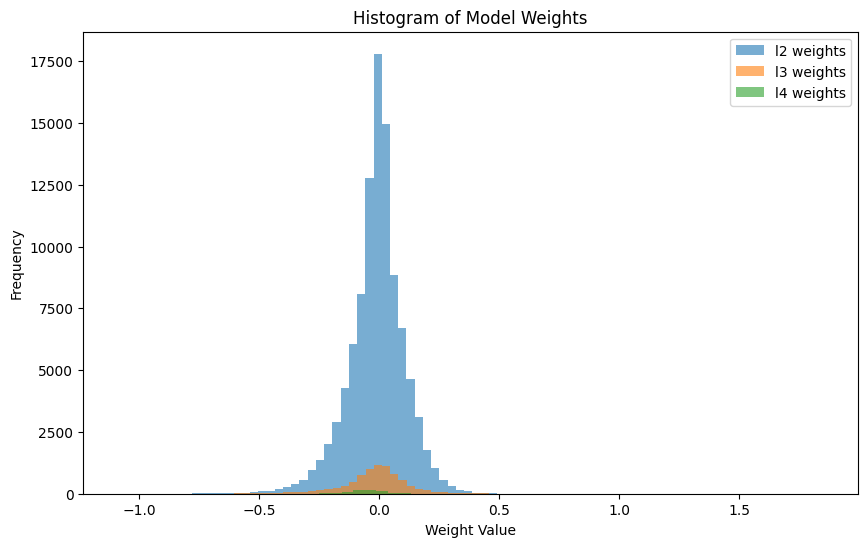

In [5]:
import torch
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model
# Get the model weights from each layer
l2_weights = model.l2.weight.detach().cpu().numpy()  # .detach() to stop gradient tracking
l3_weights = model.l3.weight.detach().cpu().numpy()
l4_weights = model.l4.weight.detach().cpu().numpy()

# Flatten the weight matrices into 1D arrays
l2_weights_flat = l2_weights.flatten()
l3_weights_flat = l3_weights.flatten()
l4_weights_flat = l4_weights.flatten()

# Plot histograms for each layer
plt.figure(figsize=(10, 6))

plt.hist(l2_weights_flat, bins=50, alpha=0.6, label='l2 weights')
plt.hist(l3_weights_flat, bins=50, alpha=0.6, label='l3 weights')
plt.hist(l4_weights_flat, bins=50, alpha=0.6, label='l4 weights')

# Adding titles and labels
plt.title("Histogram of Model Weights")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.legend()

# Show the plot
plt.show()
